In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import re

# --- Function to extract numeric part from filenames ---
def numeric_sort_key(filename):
    # Use regular expression to extract numeric part from filename (this assumes filenames contain numbers)
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0  # Default to 0 if no number is found

# --- Load the data ---

# Paths to the dataset
train_data_path = '/kaggle/input/final-augmented-dataset/aug-and-images-20240918T063356Z-001/aug-and-images'
train_mask_data_path = '/kaggle/input/final-augmented-dataset/aug-and-masks-20240918T063354Z-001/aug-and-masks'

# Load images and masks (limit to 100 for demonstration)
training_images = sorted(os.listdir(train_data_path),key=numeric_sort_key )[0:1328]
training_masks = sorted(os.listdir(train_mask_data_path),key=numeric_sort_key )[0:1328]

# Image dimensions
row, columns = 512, 512

# Initialize arrays for images and masks
x_train = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)
y_train = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)

# Load and resize images and masks
for index, name in enumerate(training_images):
    img_path = os.path.join(train_data_path, name)
    mask_path = os.path.join(train_mask_data_path, name)
    
    if os.path.exists(mask_path):
        image = imread(img_path)
        mask = imread(mask_path)
        
        x_train[index] = image
        y_train[index] = mask

In [2]:
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0
# y_train = y_train.astype(np.float32)
y_train = (y_train > .5).astype(np.float32)

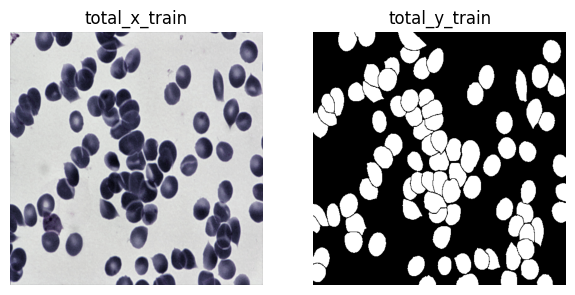

In [3]:
import matplotlib.pyplot as plt

# Plot the first image from x_train
plt.figure(figsize=(15, 5))  # Set figure size to display all images properly
index=8
plt.subplot(1, 4, 1)  # (1 row, 3 columns, first subplot)
plt.imshow(x_train[index])
plt.title('total_x_train')
plt.axis('off')  # Hide axes

# Plot the first image from augmented_masks
plt.subplot(1, 4, 2)  # (1 row, 3 columns, third subplot)
plt.imshow(y_train[index])
plt.title('total_y_train')
plt.axis('off')

# Display the images
plt.show()


In [4]:
import tensorflow.keras.backend as K

def dice_coef(a, b):

    hi = a
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a 
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [5]:

from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [6]:
# --- Define the FCN Model ---

def build_fcn(input_shape=(512, 512, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Convolutional Block 1
    c1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    c1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Convolutional Block 2
    c2 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(p1)
    c2 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Convolutional Block 3
    c3 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(p2)
    c3 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Convolutional Block 4
    c4 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(p3)
    c4 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Convolutional Block 5
    c5 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(p4)
    c5 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(c5)

    # Fully Convolutional Layers
    fcn = layers.Conv2D(num_classes, (1, 1), padding='same')(c5)
    fcn = layers.UpSampling2D(size=(2, 2))(fcn)
    fcn = layers.Conv2D(num_classes, (1, 1), padding='same')(fcn)

    fcn = layers.UpSampling2D(size=(2, 2))(fcn)
    fcn = layers.Conv2D(num_classes, (1, 1), padding='same')(fcn)

    fcn = layers.UpSampling2D(size=(2, 2))(fcn)
    fcn = layers.Conv2D(num_classes, (1, 1), padding='same')(fcn)

    fcn = layers.UpSampling2D(size=(2, 2))(fcn)
    fcn = layers.Conv2D(3, (1, 1), padding='same')(fcn)

    outputs = layers.Activation('sigmoid')(fcn)  # Sigmoid for binary segmentation

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = build_fcn(input_shape=(512, 512, 3), num_classes=1)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef,jaccard_index])

# Show model summary
model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 1)      │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 1)      │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 1)    │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 1)    │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 512, 512, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 512, 512, 3)    │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512, 512, 3)    │             

 Total params: 9,405,517 (35.88 MB)

 Trainable params: 9,405,517 (35.88 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# --- Train the Model ---
checkpoint = ModelCheckpoint('fcn_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Fit the model
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=1, epochs=20, callbacks=[checkpoint, earlystopper])



Epoch 1/20


I0000 00:00:1727711914.948369      98 service.cc:145] XLA service 0x79a5cc01bb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727711914.948466      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/1062 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - dice_coef: 0.3923 - jaccard_index: 0.2443 - loss: 0.6926   

I0000 00:00:1727711922.329874      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.3316 - jaccard_index: 0.2060 - loss: 0.6755
Epoch 1: val_loss improved from inf to 0.64465, saving model to fcn_model.keras
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 62s 47ms/step - dice_coef: 0.3317 - jaccard_index: 0.2060 - loss: 0.6755 - val_dice_coef: 0.3498 - val_jaccard_index: 0.2193 - val_loss: 0.6447
Epoch 2/20
1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.3499 - jaccard_index: 0.2201 - loss: 0.6351
Epoch 2: val_loss improved from 0.64465 to 0.60547, saving model to fcn_model.keras
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - dice_coef: 0.3499 - jaccard_index: 0.2202 - loss: 0.6351 - val_dice_coef: 0.3702 - val_jaccard_index: 0.2351 - val_loss: 0.6055
Epoch 3/20
1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.3649 - jaccard_index: 0.2314 - loss: 0.5939
Epoch 3: val_loss improved from 0.60547 to 0.56553, saving model to fcn_model.keras
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - dice_coef: 0.3649 - jacc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


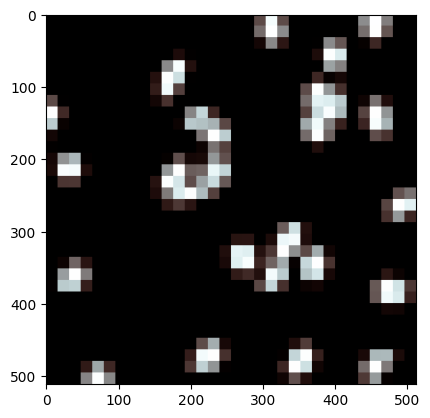

In [8]:
pred = model.predict(x_train[2:3])
pred = np.squeeze(pred)
plt.imshow(pred, cmap='gray')
plt.show()

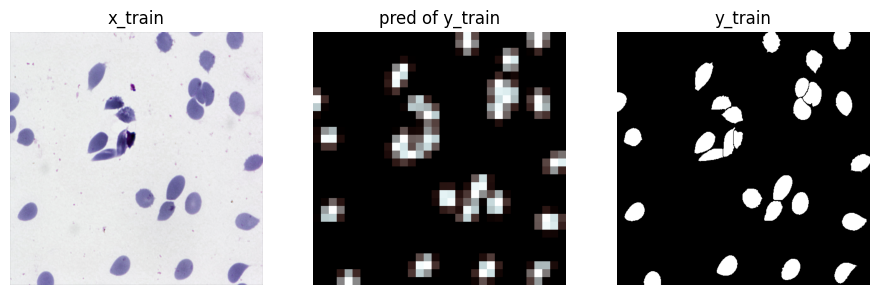

In [9]:
# Plot the first image from x_train
plt.figure(figsize=(15, 5))  # Set figure size to display all images properly
index=8
plt.subplot(1, 4, 1)  # (1 row, 3 columns, first subplot)
plt.imshow(np.squeeze(x_train[2:3]))
plt.title('x_train')
plt.axis('off')  # Hide axes

# Plot the first image from augmented_masks
plt.subplot(1, 4, 2)  # (1 row, 3 columns, third subplot)
plt.imshow(pred)
plt.title('pred of y_train')
plt.axis('off')

# Plot the first image from augmented_masks
plt.subplot(1, 4, 3)  # (1 row, 3 columns, third subplot)
plt.imshow(np.squeeze(y_train[2:3]))
plt.title('y_train')
plt.axis('off')

# Display the images
plt.show()

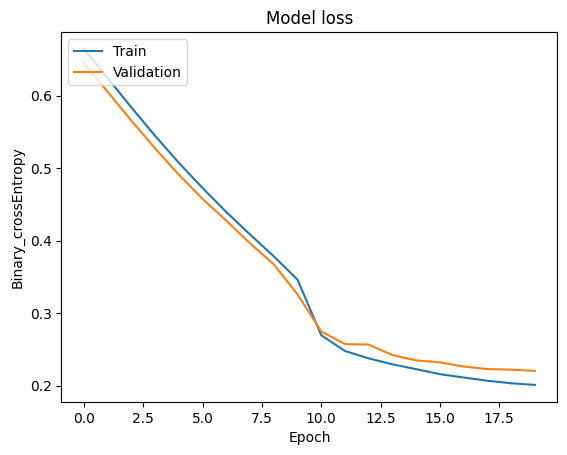

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

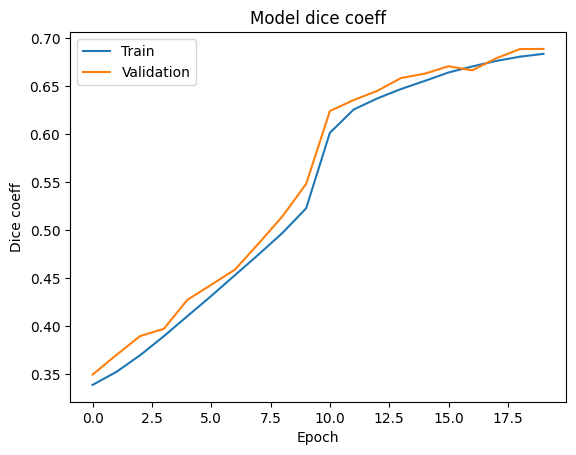

In [11]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

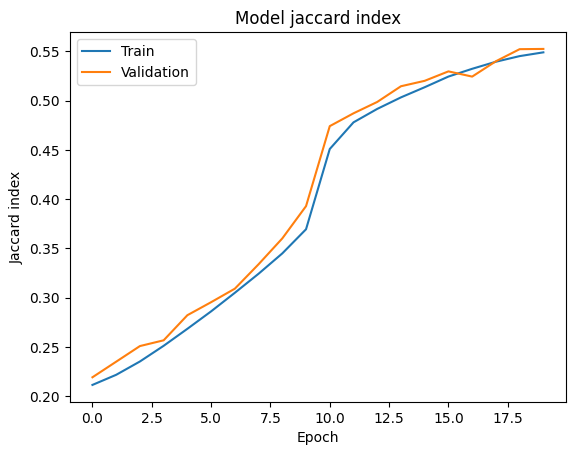

In [12]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()